In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 pr9b3bpw


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pr9b3bpw:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:5.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                        | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                | 1/2604 [00:01<47:13,  1.09s/it]

  0%|▎                                                                                                                                               | 6/2604 [00:01<06:38,  6.51it/s]

  0%|▌                                                                                                                                              | 11/2604 [00:01<03:29, 12.40it/s]

  1%|▉                                                                                                                                              | 16/2604 [00:01<02:22, 18.21it/s]

  1%|█▏                                                                                                                                             | 21/2604 [00:01<01:49, 23.61it/s]

  1%|█▍                                                                                                                                             | 26/2604 [00:01<01:30, 28.36it/s]

  1%|█▋                                                                                                                                             | 31/2604 [00:01<01:19, 32.29it/s]

  1%|█▉                                                                                                                                             | 36/2604 [00:01<01:12, 35.43it/s]

  2%|██▎                                                                                                                                            | 41/2604 [00:01<01:07, 37.91it/s]

  2%|██▌                                                                                                                                            | 46/2604 [00:02<01:04, 39.70it/s]

  2%|██▊                                                                                                                                            | 51/2604 [00:02<01:02, 41.03it/s]

  2%|███                                                                                                                                            | 56/2604 [00:02<01:00, 42.00it/s]

  2%|███▎                                                                                                                                           | 61/2604 [00:02<00:59, 42.76it/s]

  3%|███▌                                                                                                                                           | 66/2604 [00:02<00:58, 43.23it/s]

  3%|███▉                                                                                                                                           | 71/2604 [00:02<00:58, 43.57it/s]

  3%|████▏                                                                                                                                          | 76/2604 [00:02<00:57, 43.89it/s]

  3%|████▍                                                                                                                                          | 81/2604 [00:02<00:57, 44.03it/s]

  3%|████▋                                                                                                                                          | 86/2604 [00:03<00:57, 44.14it/s]

  3%|████▉                                                                                                                                          | 91/2604 [00:03<00:56, 44.23it/s]

  4%|█████▎                                                                                                                                         | 96/2604 [00:03<00:56, 44.33it/s]

  4%|█████▌                                                                                                                                        | 101/2604 [00:03<00:56, 44.35it/s]

  4%|█████▊                                                                                                                                        | 106/2604 [00:03<00:56, 44.34it/s]

  4%|██████                                                                                                                                        | 111/2604 [00:03<00:56, 44.43it/s]

  4%|██████▎                                                                                                                                       | 116/2604 [00:03<00:56, 44.41it/s]

  5%|██████▌                                                                                                                                       | 121/2604 [00:03<00:55, 44.39it/s]

  5%|██████▊                                                                                                                                       | 126/2604 [00:03<00:55, 44.40it/s]

  5%|███████▏                                                                                                                                      | 131/2604 [00:04<00:55, 44.45it/s]

  5%|███████▍                                                                                                                                      | 136/2604 [00:04<00:55, 44.42it/s]

  5%|███████▋                                                                                                                                      | 141/2604 [00:04<00:55, 44.40it/s]

  6%|███████▉                                                                                                                                      | 146/2604 [00:04<00:55, 44.46it/s]

  6%|████████▏                                                                                                                                     | 151/2604 [00:04<00:55, 44.43it/s]

  6%|████████▌                                                                                                                                     | 156/2604 [00:04<00:55, 44.40it/s]

  6%|████████▊                                                                                                                                     | 161/2604 [00:04<00:55, 44.39it/s]

  6%|█████████                                                                                                                                     | 166/2604 [00:04<00:54, 44.40it/s]

  7%|█████████▎                                                                                                                                    | 171/2604 [00:04<00:54, 44.40it/s]

  7%|█████████▌                                                                                                                                    | 176/2604 [00:05<00:54, 44.37it/s]

  7%|█████████▊                                                                                                                                    | 181/2604 [00:05<00:54, 44.45it/s]

  7%|██████████▏                                                                                                                                   | 186/2604 [00:05<00:54, 44.42it/s]

  7%|██████████▍                                                                                                                                   | 191/2604 [00:05<00:54, 44.41it/s]

  8%|██████████▋                                                                                                                                   | 196/2604 [00:05<00:54, 44.39it/s]

  8%|██████████▉                                                                                                                                   | 201/2604 [00:05<00:54, 44.46it/s]

  8%|███████████▏                                                                                                                                  | 206/2604 [00:05<00:53, 44.44it/s]

  8%|███████████▌                                                                                                                                  | 211/2604 [00:05<00:53, 44.42it/s]

  8%|███████████▊                                                                                                                                  | 216/2604 [00:05<00:53, 44.48it/s]

  8%|████████████                                                                                                                                  | 221/2604 [00:06<00:53, 44.44it/s]

  9%|████████████▎                                                                                                                                 | 226/2604 [00:06<00:53, 44.37it/s]

  9%|████████████▌                                                                                                                                 | 231/2604 [00:06<00:53, 44.36it/s]

  9%|████████████▊                                                                                                                                 | 236/2604 [00:06<00:53, 44.45it/s]

  9%|█████████████▏                                                                                                                                | 241/2604 [00:06<00:53, 44.38it/s]

  9%|█████████████▍                                                                                                                                | 246/2604 [00:06<00:53, 44.32it/s]

 10%|█████████████▋                                                                                                                                | 251/2604 [00:06<00:53, 44.32it/s]

 10%|█████████████▉                                                                                                                                | 256/2604 [00:06<00:52, 44.33it/s]

 10%|██████████████▏                                                                                                                               | 261/2604 [00:06<00:52, 44.33it/s]

 10%|██████████████▌                                                                                                                               | 266/2604 [00:07<00:52, 44.39it/s]

 10%|██████████████▊                                                                                                                               | 271/2604 [00:07<00:52, 44.36it/s]

 11%|███████████████                                                                                                                               | 276/2604 [00:07<00:52, 44.40it/s]

 11%|███████████████▎                                                                                                                              | 281/2604 [00:07<00:52, 44.42it/s]

 11%|███████████████▌                                                                                                                              | 286/2604 [00:07<00:52, 44.34it/s]

 11%|███████████████▊                                                                                                                              | 291/2604 [00:07<00:52, 44.23it/s]

 11%|████████████████▏                                                                                                                             | 296/2604 [00:07<00:52, 44.28it/s]

 12%|████████████████▍                                                                                                                             | 301/2604 [00:07<00:51, 44.32it/s]

 12%|████████████████▋                                                                                                                             | 306/2604 [00:07<00:51, 44.35it/s]

 12%|████████████████▉                                                                                                                             | 311/2604 [00:08<00:51, 44.38it/s]

 12%|█████████████████▏                                                                                                                            | 316/2604 [00:08<00:51, 44.45it/s]

 12%|█████████████████▌                                                                                                                            | 321/2604 [00:08<00:51, 44.43it/s]

 13%|█████████████████▊                                                                                                                            | 326/2604 [00:08<00:51, 44.44it/s]

 13%|██████████████████                                                                                                                            | 331/2604 [00:08<00:51, 44.43it/s]

 13%|██████████████████▎                                                                                                                           | 336/2604 [00:08<00:50, 44.49it/s]

 13%|██████████████████▌                                                                                                                           | 341/2604 [00:08<00:50, 44.48it/s]

 13%|██████████████████▊                                                                                                                           | 346/2604 [00:08<00:50, 44.44it/s]

 13%|███████████████████▏                                                                                                                          | 351/2604 [00:08<00:50, 44.48it/s]

 14%|███████████████████▍                                                                                                                          | 356/2604 [00:09<00:50, 44.44it/s]

 14%|███████████████████▋                                                                                                                          | 361/2604 [00:09<00:50, 44.41it/s]

 14%|███████████████████▉                                                                                                                          | 366/2604 [00:09<00:50, 44.43it/s]

 14%|████████████████████▏                                                                                                                         | 371/2604 [00:09<00:50, 44.48it/s]

 14%|████████████████████▌                                                                                                                         | 376/2604 [00:09<00:50, 44.44it/s]

 15%|████████████████████▊                                                                                                                         | 381/2604 [00:09<00:50, 44.43it/s]

 15%|█████████████████████                                                                                                                         | 386/2604 [00:09<00:49, 44.47it/s]

 15%|█████████████████████▎                                                                                                                        | 391/2604 [00:09<00:49, 44.46it/s]

 15%|█████████████████████▌                                                                                                                        | 396/2604 [00:09<00:49, 44.43it/s]

 15%|█████████████████████▊                                                                                                                        | 401/2604 [00:10<00:49, 44.44it/s]

 16%|██████████████████████▏                                                                                                                       | 406/2604 [00:10<00:49, 44.39it/s]

 16%|██████████████████████▍                                                                                                                       | 411/2604 [00:10<00:49, 44.46it/s]

 16%|██████████████████████▋                                                                                                                       | 416/2604 [00:10<00:49, 44.44it/s]

 16%|██████████████████████▉                                                                                                                       | 421/2604 [00:10<00:49, 44.44it/s]

 16%|███████████████████████▏                                                                                                                      | 426/2604 [00:10<00:48, 44.49it/s]

 17%|███████████████████████▌                                                                                                                      | 431/2604 [00:10<00:48, 44.46it/s]

 17%|███████████████████████▊                                                                                                                      | 436/2604 [00:10<00:48, 44.45it/s]

 17%|████████████████████████                                                                                                                      | 441/2604 [00:10<00:48, 44.51it/s]

 17%|████████████████████████▎                                                                                                                     | 446/2604 [00:11<00:48, 44.47it/s]

 17%|████████████████████████▌                                                                                                                     | 451/2604 [00:11<00:48, 44.47it/s]

 18%|████████████████████████▊                                                                                                                     | 456/2604 [00:11<00:48, 44.42it/s]

 18%|█████████████████████████▏                                                                                                                    | 461/2604 [00:11<00:48, 44.50it/s]

 18%|█████████████████████████▍                                                                                                                    | 466/2604 [00:11<00:48, 44.47it/s]

 18%|█████████████████████████▋                                                                                                                    | 471/2604 [00:11<00:47, 44.45it/s]

 18%|█████████████████████████▉                                                                                                                    | 476/2604 [00:11<00:47, 44.49it/s]

 18%|██████████████████████████▏                                                                                                                   | 481/2604 [00:11<00:47, 44.34it/s]

 19%|██████████████████████████▌                                                                                                                   | 486/2604 [00:12<00:47, 44.22it/s]

 19%|██████████████████████████▊                                                                                                                   | 491/2604 [00:12<00:47, 44.20it/s]

 19%|███████████████████████████                                                                                                                   | 496/2604 [00:12<00:47, 44.33it/s]

 19%|███████████████████████████▎                                                                                                                  | 501/2604 [00:12<00:47, 44.36it/s]

 19%|███████████████████████████▌                                                                                                                  | 506/2604 [00:12<00:47, 44.36it/s]

 20%|███████████████████████████▊                                                                                                                  | 511/2604 [00:12<00:47, 44.49it/s]

 20%|████████████████████████████▏                                                                                                                 | 516/2604 [00:12<00:46, 45.22it/s]

 20%|████████████████████████████▍                                                                                                                 | 521/2604 [00:12<00:45, 45.73it/s]

 20%|████████████████████████████▋                                                                                                                 | 526/2604 [00:12<00:45, 46.08it/s]

 20%|████████████████████████████▉                                                                                                                 | 531/2604 [00:12<00:44, 46.39it/s]

 21%|█████████████████████████████▏                                                                                                                | 536/2604 [00:13<00:44, 46.55it/s]

 21%|█████████████████████████████▌                                                                                                                | 541/2604 [00:13<00:44, 46.67it/s]

 21%|█████████████████████████████▊                                                                                                                | 546/2604 [00:13<00:44, 46.76it/s]

 21%|██████████████████████████████                                                                                                                | 551/2604 [00:13<00:43, 46.87it/s]

 21%|██████████████████████████████▎                                                                                                               | 556/2604 [00:13<00:43, 46.88it/s]

 22%|██████████████████████████████▌                                                                                                               | 561/2604 [00:13<00:43, 46.92it/s]

 22%|██████████████████████████████▊                                                                                                               | 566/2604 [00:13<00:43, 46.97it/s]

 22%|███████████████████████████████▏                                                                                                              | 571/2604 [00:13<00:43, 46.96it/s]

 22%|███████████████████████████████▍                                                                                                              | 576/2604 [00:13<00:43, 46.93it/s]

 22%|███████████████████████████████▋                                                                                                              | 581/2604 [00:14<00:43, 46.95it/s]

 23%|███████████████████████████████▉                                                                                                              | 586/2604 [00:14<00:42, 46.96it/s]

 23%|████████████████████████████████▏                                                                                                             | 591/2604 [00:14<00:42, 47.01it/s]

 23%|████████████████████████████████▌                                                                                                             | 596/2604 [00:14<00:42, 47.01it/s]

 23%|████████████████████████████████▊                                                                                                             | 601/2604 [00:14<00:42, 46.99it/s]

 23%|█████████████████████████████████                                                                                                             | 606/2604 [00:14<00:42, 47.03it/s]

 23%|█████████████████████████████████▎                                                                                                            | 611/2604 [00:14<00:42, 47.02it/s]

 24%|█████████████████████████████████▌                                                                                                            | 616/2604 [00:14<00:42, 47.02it/s]

 24%|█████████████████████████████████▊                                                                                                            | 621/2604 [00:14<00:42, 47.00it/s]

 24%|██████████████████████████████████▏                                                                                                           | 626/2604 [00:15<00:42, 47.03it/s]

 24%|██████████████████████████████████▍                                                                                                           | 631/2604 [00:15<00:41, 47.01it/s]

 24%|██████████████████████████████████▋                                                                                                           | 636/2604 [00:15<00:41, 47.01it/s]

 25%|██████████████████████████████████▉                                                                                                           | 641/2604 [00:15<00:41, 47.03it/s]

 25%|███████████████████████████████████▏                                                                                                          | 646/2604 [00:15<00:41, 46.96it/s]

 25%|███████████████████████████████████▌                                                                                                          | 651/2604 [00:15<00:41, 46.96it/s]

 25%|███████████████████████████████████▊                                                                                                          | 656/2604 [00:15<00:41, 46.96it/s]

 25%|████████████████████████████████████                                                                                                          | 661/2604 [00:15<00:41, 46.98it/s]

 26%|████████████████████████████████████▎                                                                                                         | 666/2604 [00:15<00:41, 46.97it/s]

 26%|████████████████████████████████████▌                                                                                                         | 671/2604 [00:15<00:41, 46.98it/s]

 26%|████████████████████████████████████▊                                                                                                         | 676/2604 [00:16<00:41, 46.31it/s]

 26%|█████████████████████████████████████▏                                                                                                        | 681/2604 [00:16<00:42, 45.70it/s]

 26%|█████████████████████████████████████▍                                                                                                        | 686/2604 [00:16<00:42, 45.30it/s]

 27%|█████████████████████████████████████▋                                                                                                        | 691/2604 [00:16<00:42, 45.03it/s]

 27%|█████████████████████████████████████▉                                                                                                        | 696/2604 [00:16<00:42, 44.93it/s]

 27%|██████████████████████████████████████▏                                                                                                       | 701/2604 [00:16<00:42, 44.76it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 706/2604 [00:16<00:42, 44.66it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 711/2604 [00:16<00:42, 44.66it/s]

 27%|███████████████████████████████████████                                                                                                       | 716/2604 [00:16<00:42, 44.57it/s]

 28%|███████████████████████████████████████▎                                                                                                      | 721/2604 [00:17<00:42, 44.52it/s]

 28%|███████████████████████████████████████▌                                                                                                      | 726/2604 [00:17<00:42, 44.49it/s]

 28%|███████████████████████████████████████▊                                                                                                      | 731/2604 [00:17<00:42, 44.42it/s]

 28%|████████████████████████████████████████▏                                                                                                     | 736/2604 [00:17<00:41, 44.49it/s]

 28%|████████████████████████████████████████▍                                                                                                     | 741/2604 [00:17<00:41, 44.46it/s]

 29%|████████████████████████████████████████▋                                                                                                     | 746/2604 [00:17<00:41, 44.49it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 751/2604 [00:17<00:41, 44.48it/s]

 29%|█████████████████████████████████████████▏                                                                                                    | 756/2604 [00:17<00:41, 44.45it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 761/2604 [00:17<00:41, 44.44it/s]

 29%|█████████████████████████████████████████▊                                                                                                    | 766/2604 [00:18<00:41, 44.49it/s]

 30%|██████████████████████████████████████████                                                                                                    | 771/2604 [00:18<00:41, 44.46it/s]

 30%|██████████████████████████████████████████▎                                                                                                   | 776/2604 [00:18<00:41, 44.43it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 781/2604 [00:18<00:40, 44.49it/s]

 30%|██████████████████████████████████████████▊                                                                                                   | 786/2604 [00:18<00:40, 44.47it/s]

 30%|███████████████████████████████████████████▏                                                                                                  | 791/2604 [00:18<00:40, 44.43it/s]

 31%|███████████████████████████████████████████▍                                                                                                  | 796/2604 [00:18<00:40, 44.42it/s]

 31%|███████████████████████████████████████████▋                                                                                                  | 801/2604 [00:18<00:40, 44.49it/s]

 31%|███████████████████████████████████████████▉                                                                                                  | 806/2604 [00:19<00:40, 44.46it/s]

 31%|████████████████████████████████████████████▏                                                                                                 | 811/2604 [00:19<00:40, 44.44it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 816/2604 [00:19<00:40, 44.49it/s]

 32%|████████████████████████████████████████████▊                                                                                                 | 821/2604 [00:19<00:40, 44.35it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 826/2604 [00:19<00:40, 44.42it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 831/2604 [00:19<00:39, 44.42it/s]

 32%|█████████████████████████████████████████████▌                                                                                                | 836/2604 [00:19<00:39, 44.43it/s]

 32%|█████████████████████████████████████████████▊                                                                                                | 841/2604 [00:19<00:39, 44.47it/s]

 32%|██████████████████████████████████████████████▏                                                                                               | 846/2604 [00:19<00:39, 44.45it/s]

 33%|██████████████████████████████████████████████▍                                                                                               | 851/2604 [00:20<00:39, 44.45it/s]

 33%|██████████████████████████████████████████████▋                                                                                               | 856/2604 [00:20<00:39, 44.51it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 861/2604 [00:20<00:39, 44.47it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 866/2604 [00:20<00:39, 44.46it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 871/2604 [00:20<00:38, 44.46it/s]

 34%|███████████████████████████████████████████████▊                                                                                              | 876/2604 [00:20<00:38, 44.47it/s]

 34%|████████████████████████████████████████████████                                                                                              | 881/2604 [00:20<00:38, 44.43it/s]

 34%|████████████████████████████████████████████████▎                                                                                             | 886/2604 [00:20<00:38, 44.43it/s]

 34%|████████████████████████████████████████████████▌                                                                                             | 891/2604 [00:20<00:38, 44.50it/s]

 34%|████████████████████████████████████████████████▊                                                                                             | 896/2604 [00:21<00:38, 44.45it/s]

 35%|█████████████████████████████████████████████████▏                                                                                            | 901/2604 [00:21<00:38, 44.43it/s]

 35%|█████████████████████████████████████████████████▍                                                                                            | 906/2604 [00:21<00:38, 44.43it/s]

 35%|█████████████████████████████████████████████████▋                                                                                            | 911/2604 [00:21<00:38, 44.45it/s]

 35%|█████████████████████████████████████████████████▉                                                                                            | 916/2604 [00:21<00:38, 44.42it/s]

 35%|██████████████████████████████████████████████████▏                                                                                           | 921/2604 [00:21<00:37, 44.33it/s]

 36%|██████████████████████████████████████████████████▍                                                                                           | 926/2604 [00:21<00:37, 45.05it/s]

 36%|██████████████████████████████████████████████████▊                                                                                           | 931/2604 [00:21<00:36, 45.65it/s]

 36%|███████████████████████████████████████████████████                                                                                           | 936/2604 [00:21<00:36, 46.03it/s]

 36%|███████████████████████████████████████████████████▎                                                                                          | 941/2604 [00:22<00:35, 46.35it/s]

 36%|███████████████████████████████████████████████████▌                                                                                          | 946/2604 [00:22<00:35, 46.53it/s]

 37%|███████████████████████████████████████████████████▊                                                                                          | 951/2604 [00:22<00:35, 46.66it/s]

 37%|████████████████████████████████████████████████████▏                                                                                         | 956/2604 [00:22<00:35, 46.75it/s]

 37%|████████████████████████████████████████████████████▍                                                                                         | 961/2604 [00:22<00:35, 46.86it/s]

 37%|████████████████████████████████████████████████████▋                                                                                         | 966/2604 [00:22<00:34, 46.88it/s]

 37%|████████████████████████████████████████████████████▉                                                                                         | 971/2604 [00:22<00:34, 46.92it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                        | 976/2604 [00:22<00:34, 46.97it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                        | 981/2604 [00:22<00:34, 46.97it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                        | 986/2604 [00:22<00:34, 46.96it/s]

 38%|██████████████████████████████████████████████████████                                                                                        | 991/2604 [00:23<00:34, 46.97it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                       | 996/2604 [00:23<00:34, 46.99it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                      | 1001/2604 [00:23<00:34, 46.98it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                      | 1006/2604 [00:23<00:34, 46.98it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 1011/2604 [00:23<00:33, 47.01it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 1016/2604 [00:23<00:33, 46.99it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 1021/2604 [00:23<00:33, 46.98it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 1026/2604 [00:23<00:33, 46.97it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                     | 1031/2604 [00:23<00:33, 47.02it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 1036/2604 [00:24<00:33, 47.02it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 1041/2604 [00:24<00:33, 46.03it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                    | 1046/2604 [00:24<00:34, 45.26it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 1051/2604 [00:24<00:34, 44.77it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1056/2604 [00:24<00:34, 44.42it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 1061/2604 [00:24<00:34, 44.16it/s]

 41%|█████████████████████████████████████████████████████████▋                                                                                   | 1066/2604 [00:24<00:34, 44.00it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 1071/2604 [00:24<00:34, 43.88it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                  | 1076/2604 [00:24<00:34, 43.80it/s]

 42%|██████████████████████████████████████████████████████████▌                                                                                  | 1081/2604 [00:25<00:34, 43.73it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 1086/2604 [00:25<00:34, 43.71it/s]

 42%|███████████████████████████████████████████████████████████                                                                                  | 1091/2604 [00:25<00:34, 43.69it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 1096/2604 [00:25<00:34, 43.66it/s]

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 1101/2604 [00:25<00:34, 43.64it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                 | 1106/2604 [00:25<00:34, 43.63it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                                | 1111/2604 [00:25<00:34, 43.62it/s]

 43%|████████████████████████████████████████████████████████████▍                                                                                | 1116/2604 [00:25<00:34, 43.62it/s]

 43%|████████████████████████████████████████████████████████████▋                                                                                | 1121/2604 [00:25<00:34, 43.61it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                | 1126/2604 [00:26<00:33, 43.61it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 1131/2604 [00:26<00:33, 43.60it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 1136/2604 [00:26<00:33, 43.60it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 1141/2604 [00:26<00:33, 43.62it/s]

 44%|██████████████████████████████████████████████████████████████                                                                               | 1146/2604 [00:26<00:33, 43.61it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                              | 1151/2604 [00:26<00:33, 43.62it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1156/2604 [00:26<00:33, 43.62it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 1161/2604 [00:26<00:33, 43.62it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 1166/2604 [00:27<00:32, 43.60it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 1171/2604 [00:27<00:32, 43.72it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 1176/2604 [00:27<00:32, 43.85it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 1181/2604 [00:27<00:32, 43.77it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                            | 1186/2604 [00:27<00:32, 43.74it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 1191/2604 [00:27<00:32, 43.69it/s]

 46%|████████████████████████████████████████████████████████████████▊                                                                            | 1196/2604 [00:27<00:32, 43.66it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                            | 1201/2604 [00:27<00:32, 43.66it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 1206/2604 [00:27<00:32, 43.67it/s]

 47%|█████████████████████████████████████████████████████████████████▌                                                                           | 1211/2604 [00:28<00:31, 43.65it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 1216/2604 [00:28<00:31, 43.64it/s]

 47%|██████████████████████████████████████████████████████████████████                                                                           | 1221/2604 [00:28<00:31, 43.63it/s]

 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 1226/2604 [00:28<00:31, 43.63it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 1231/2604 [00:28<00:31, 43.62it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                          | 1236/2604 [00:28<00:31, 43.63it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                         | 1241/2604 [00:28<00:31, 43.62it/s]

 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 1246/2604 [00:28<00:31, 43.63it/s]

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 1251/2604 [00:28<00:31, 43.63it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 1256/2604 [00:29<00:30, 43.62it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 1261/2604 [00:29<00:30, 43.63it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 1266/2604 [00:29<00:30, 43.62it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 1271/2604 [00:29<00:30, 43.61it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 1276/2604 [00:29<00:30, 43.62it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 1281/2604 [00:29<00:30, 43.63it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1286/2604 [00:29<00:30, 43.63it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1291/2604 [00:29<00:30, 43.63it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                      | 1296/2604 [00:30<00:29, 43.62it/s]

 50%|██████████████████████████████████████████████████████████████████████▍                                                                      | 1301/2604 [00:30<00:29, 43.61it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 1306/2604 [00:30<00:29, 43.61it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 1311/2604 [00:30<00:29, 43.62it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 1316/2604 [00:30<00:29, 43.55it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                     | 1321/2604 [00:30<00:29, 43.56it/s]

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 1326/2604 [00:30<00:29, 43.59it/s]

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 1331/2604 [00:30<00:30, 42.38it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 1336/2604 [00:30<00:29, 42.73it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                    | 1341/2604 [00:31<00:29, 42.99it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                    | 1346/2604 [00:31<00:29, 43.18it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 1351/2604 [00:31<00:28, 43.30it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 1356/2604 [00:31<00:28, 43.41it/s]

 52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 1361/2604 [00:31<00:28, 43.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 1366/2604 [00:31<00:28, 43.50it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 1371/2604 [00:31<00:28, 43.53it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 1376/2604 [00:31<00:28, 43.56it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 1381/2604 [00:31<00:28, 43.58it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 1386/2604 [00:32<00:27, 43.59it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 1391/2604 [00:32<00:27, 43.61it/s]

 54%|███████████████████████████████████████████████████████████████████████████▌                                                                 | 1396/2604 [00:32<00:27, 43.62it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 1401/2604 [00:32<00:27, 43.60it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 1406/2604 [00:32<00:27, 43.62it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 1411/2604 [00:32<00:27, 43.63it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 1416/2604 [00:32<00:27, 43.62it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1421/2604 [00:32<00:27, 43.62it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 1426/2604 [00:32<00:27, 43.62it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 1431/2604 [00:33<00:26, 43.62it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 1436/2604 [00:33<00:26, 43.61it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 1441/2604 [00:33<00:26, 43.63it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 1446/2604 [00:33<00:26, 43.62it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 1451/2604 [00:33<00:26, 43.63it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1456/2604 [00:33<00:26, 43.61it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 1461/2604 [00:33<00:26, 43.61it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 1466/2604 [00:33<00:26, 43.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                             | 1471/2604 [00:34<00:25, 43.61it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 1476/2604 [00:34<00:25, 43.58it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 1481/2604 [00:34<00:25, 43.44it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 1486/2604 [00:34<00:25, 43.43it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                            | 1491/2604 [00:34<00:25, 43.41it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 1496/2604 [00:34<00:25, 43.41it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 1501/2604 [00:34<00:25, 43.37it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1506/2604 [00:34<00:25, 43.35it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 1511/2604 [00:34<00:25, 43.35it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 1516/2604 [00:35<00:25, 43.37it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 1521/2604 [00:35<00:24, 43.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 1526/2604 [00:35<00:24, 43.38it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 1531/2604 [00:35<00:24, 43.37it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 1536/2604 [00:35<00:24, 43.39it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1541/2604 [00:35<00:24, 43.33it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 1546/2604 [00:35<00:24, 43.36it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 1551/2604 [00:35<00:24, 43.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1556/2604 [00:35<00:24, 43.30it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1561/2604 [00:36<00:24, 43.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1566/2604 [00:36<00:23, 43.37it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 1571/2604 [00:36<00:23, 43.37it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1576/2604 [00:36<00:23, 43.34it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1581/2604 [00:36<00:23, 43.35it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1586/2604 [00:36<00:23, 43.35it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1591/2604 [00:36<00:23, 43.37it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1596/2604 [00:36<00:23, 43.39it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1601/2604 [00:37<00:23, 43.42it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1606/2604 [00:37<00:23, 43.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1611/2604 [00:37<00:22, 43.41it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1616/2604 [00:37<00:22, 43.43it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1621/2604 [00:37<00:22, 43.42it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                     | 1626/2604 [00:37<00:22, 43.44it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1631/2604 [00:37<00:22, 43.47it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1636/2604 [00:37<00:22, 43.45it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1641/2604 [00:37<00:22, 43.47it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1646/2604 [00:38<00:22, 43.44it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1651/2604 [00:38<00:21, 43.38it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1656/2604 [00:38<00:21, 43.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1661/2604 [00:38<00:21, 43.28it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1666/2604 [00:38<00:21, 43.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1671/2604 [00:38<00:21, 43.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1676/2604 [00:38<00:21, 43.18it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 1681/2604 [00:38<00:21, 43.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1686/2604 [00:38<00:21, 43.32it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1691/2604 [00:39<00:21, 43.42it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1696/2604 [00:39<00:20, 43.48it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1701/2604 [00:39<00:20, 43.52it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1706/2604 [00:39<00:20, 43.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1711/2604 [00:39<00:20, 43.61it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1716/2604 [00:39<00:20, 43.61it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1721/2604 [00:39<00:20, 43.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1726/2604 [00:39<00:20, 43.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1731/2604 [00:40<00:20, 43.63it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 1736/2604 [00:40<00:19, 43.61it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1741/2604 [00:40<00:19, 43.63it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1746/2604 [00:40<00:19, 43.64it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1751/2604 [00:40<00:19, 43.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 1756/2604 [00:40<00:19, 43.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1761/2604 [00:40<00:19, 43.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1766/2604 [00:40<00:19, 43.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1771/2604 [00:40<00:19, 43.62it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1776/2604 [00:41<00:18, 43.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1781/2604 [00:41<00:18, 43.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1786/2604 [00:41<00:18, 43.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1791/2604 [00:41<00:18, 43.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1796/2604 [00:41<00:18, 43.62it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1801/2604 [00:41<00:18, 43.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1806/2604 [00:41<00:18, 43.61it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1811/2604 [00:41<00:18, 43.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1816/2604 [00:41<00:18, 43.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1821/2604 [00:42<00:17, 43.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1826/2604 [00:42<00:17, 43.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1831/2604 [00:42<00:17, 43.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1836/2604 [00:42<00:17, 43.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1841/2604 [00:42<00:17, 43.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1846/2604 [00:42<00:17, 43.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1851/2604 [00:42<00:17, 43.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1856/2604 [00:42<00:17, 43.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1861/2604 [00:42<00:17, 43.62it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1866/2604 [00:43<00:16, 43.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1871/2604 [00:43<00:16, 43.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1876/2604 [00:43<00:16, 43.36it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1881/2604 [00:43<00:16, 43.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1886/2604 [00:43<00:16, 43.49it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1891/2604 [00:43<00:16, 43.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1896/2604 [00:43<00:16, 43.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1901/2604 [00:43<00:16, 43.60it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1906/2604 [00:44<00:15, 43.63it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1911/2604 [00:44<00:15, 43.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1916/2604 [00:44<00:15, 43.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1921/2604 [00:44<00:15, 43.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1926/2604 [00:44<00:15, 43.95it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1931/2604 [00:44<00:15, 44.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1936/2604 [00:44<00:14, 45.19it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1941/2604 [00:44<00:14, 45.57it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1946/2604 [00:44<00:14, 45.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1951/2604 [00:45<00:14, 46.02it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1956/2604 [00:45<00:14, 46.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1961/2604 [00:45<00:13, 46.26it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1966/2604 [00:45<00:13, 46.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1971/2604 [00:45<00:13, 46.36it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1976/2604 [00:45<00:13, 46.40it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1981/2604 [00:45<00:13, 46.42it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1986/2604 [00:45<00:13, 46.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1991/2604 [00:45<00:13, 46.44it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1996/2604 [00:45<00:13, 46.45it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2001/2604 [00:46<00:12, 46.44it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2006/2604 [00:46<00:12, 46.46it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2011/2604 [00:46<00:12, 46.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2016/2604 [00:46<00:12, 46.46it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2021/2604 [00:46<00:12, 46.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2026/2604 [00:46<00:12, 46.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2031/2604 [00:46<00:12, 46.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2036/2604 [00:46<00:12, 46.48it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2041/2604 [00:46<00:12, 46.48it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2046/2604 [00:47<00:12, 46.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2051/2604 [00:47<00:11, 46.48it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2056/2604 [00:47<00:11, 46.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2061/2604 [00:47<00:11, 46.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2066/2604 [00:47<00:11, 46.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2071/2604 [00:47<00:11, 46.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2076/2604 [00:47<00:11, 46.48it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2081/2604 [00:47<00:11, 46.49it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2086/2604 [00:47<00:11, 46.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2091/2604 [00:48<00:11, 46.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2096/2604 [00:48<00:10, 46.47it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2101/2604 [00:48<00:10, 46.47it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2106/2604 [00:48<00:10, 46.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2111/2604 [00:48<00:10, 45.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2116/2604 [00:48<00:10, 44.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2121/2604 [00:48<00:10, 44.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2126/2604 [00:48<00:10, 44.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2131/2604 [00:48<00:10, 44.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2136/2604 [00:49<00:10, 43.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2141/2604 [00:49<00:10, 43.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2146/2604 [00:49<00:10, 43.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2151/2604 [00:49<00:10, 43.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2156/2604 [00:49<00:10, 43.74it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2161/2604 [00:49<00:10, 43.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2166/2604 [00:49<00:10, 43.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2171/2604 [00:49<00:09, 43.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2176/2604 [00:49<00:09, 43.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2181/2604 [00:50<00:09, 43.66it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2186/2604 [00:50<00:09, 43.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2191/2604 [00:50<00:09, 43.66it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2196/2604 [00:50<00:09, 43.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2201/2604 [00:50<00:09, 43.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2206/2604 [00:50<00:09, 43.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2211/2604 [00:50<00:09, 43.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2216/2604 [00:50<00:08, 43.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2221/2604 [00:50<00:08, 43.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2226/2604 [00:51<00:08, 43.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2231/2604 [00:51<00:08, 43.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2236/2604 [00:51<00:08, 43.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2241/2604 [00:51<00:08, 43.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2246/2604 [00:51<00:08, 43.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2251/2604 [00:51<00:08, 43.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2256/2604 [00:51<00:07, 43.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2261/2604 [00:51<00:07, 43.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2266/2604 [00:52<00:07, 43.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2271/2604 [00:52<00:07, 43.66it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2276/2604 [00:52<00:07, 43.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2281/2604 [00:52<00:07, 43.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2286/2604 [00:52<00:07, 43.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2291/2604 [00:52<00:07, 43.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2296/2604 [00:52<00:07, 43.58it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2301/2604 [00:52<00:06, 43.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2306/2604 [00:52<00:06, 43.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2311/2604 [00:53<00:06, 43.63it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2316/2604 [00:53<00:06, 43.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2321/2604 [00:53<00:06, 43.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2326/2604 [00:53<00:06, 43.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2331/2604 [00:53<00:06, 43.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2336/2604 [00:53<00:06, 43.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2341/2604 [00:53<00:06, 43.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2346/2604 [00:53<00:05, 43.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2351/2604 [00:53<00:05, 43.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2356/2604 [00:54<00:05, 43.59it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2361/2604 [00:54<00:05, 43.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2366/2604 [00:54<00:05, 43.63it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2371/2604 [00:54<00:05, 43.51it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2376/2604 [00:54<00:05, 43.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2381/2604 [00:54<00:05, 43.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2386/2604 [00:54<00:04, 43.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2391/2604 [00:54<00:04, 43.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2396/2604 [00:55<00:04, 43.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2401/2604 [00:55<00:04, 43.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2406/2604 [00:55<00:04, 43.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2411/2604 [00:55<00:04, 43.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2416/2604 [00:55<00:04, 43.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2421/2604 [00:55<00:04, 43.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2426/2604 [00:55<00:04, 43.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2431/2604 [00:55<00:03, 43.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2436/2604 [00:55<00:03, 43.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2441/2604 [00:56<00:03, 43.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2446/2604 [00:56<00:03, 43.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2451/2604 [00:56<00:03, 43.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2456/2604 [00:56<00:03, 43.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2461/2604 [00:56<00:03, 43.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2466/2604 [00:56<00:03, 43.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2471/2604 [00:56<00:03, 43.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2476/2604 [00:56<00:02, 43.64it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2481/2604 [00:56<00:02, 43.64it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2486/2604 [00:57<00:02, 43.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2491/2604 [00:57<00:02, 43.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2496/2604 [00:57<00:02, 43.63it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2501/2604 [00:57<00:02, 43.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2506/2604 [00:57<00:02, 43.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2511/2604 [00:57<00:02, 43.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2516/2604 [00:57<00:02, 43.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2521/2604 [00:57<00:01, 43.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2526/2604 [00:57<00:01, 43.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2531/2604 [00:58<00:01, 43.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2536/2604 [00:58<00:01, 43.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2541/2604 [00:58<00:01, 43.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2546/2604 [00:58<00:01, 43.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2551/2604 [00:58<00:01, 43.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2556/2604 [00:58<00:01, 43.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2561/2604 [00:58<00:00, 43.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2566/2604 [00:58<00:00, 43.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2571/2604 [00:59<00:00, 43.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2576/2604 [00:59<00:00, 43.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2581/2604 [00:59<00:00, 43.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2586/2604 [00:59<00:00, 43.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2591/2604 [00:59<00:00, 43.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [00:59<00:00, 43.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [00:59<00:00, 43.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:59<00:00, 43.53it/s]

train - OK


  0%|                                                                                                                                                         | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/339 [00:00<02:12,  2.56it/s]

  2%|██▌                                                                                                                                              | 6/339 [00:00<00:22, 14.57it/s]

  3%|████▋                                                                                                                                           | 11/339 [00:00<00:14, 23.06it/s]

  5%|██████▊                                                                                                                                         | 16/339 [00:00<00:11, 29.05it/s]

  6%|████████▉                                                                                                                                       | 21/339 [00:00<00:09, 33.27it/s]

  8%|███████████                                                                                                                                     | 26/339 [00:00<00:08, 36.22it/s]

  9%|█████████████▏                                                                                                                                  | 31/339 [00:01<00:08, 38.30it/s]

 11%|███████████████▎                                                                                                                                | 36/339 [00:01<00:07, 39.75it/s]

 12%|█████████████████▍                                                                                                                              | 41/339 [00:01<00:07, 40.77it/s]

 14%|███████████████████▌                                                                                                                            | 46/339 [00:01<00:07, 41.48it/s]

 15%|█████████████████████▋                                                                                                                          | 51/339 [00:01<00:06, 41.99it/s]

 17%|███████████████████████▊                                                                                                                        | 56/339 [00:01<00:06, 42.33it/s]

 18%|█████████████████████████▉                                                                                                                      | 61/339 [00:01<00:06, 42.57it/s]

 19%|████████████████████████████                                                                                                                    | 66/339 [00:01<00:06, 42.74it/s]

 21%|██████████████████████████████▏                                                                                                                 | 71/339 [00:02<00:06, 42.83it/s]

 22%|████████████████████████████████▎                                                                                                               | 76/339 [00:02<00:06, 43.00it/s]

 24%|██████████████████████████████████▍                                                                                                             | 81/339 [00:02<00:05, 43.10it/s]

 25%|████████████████████████████████████▌                                                                                                           | 86/339 [00:02<00:05, 43.11it/s]

 27%|██████████████████████████████████████▋                                                                                                         | 91/339 [00:02<00:05, 43.14it/s]

 28%|████████████████████████████████████████▊                                                                                                       | 96/339 [00:02<00:05, 43.16it/s]

 30%|██████████████████████████████████████████▌                                                                                                    | 101/339 [00:02<00:05, 43.18it/s]

 31%|████████████████████████████████████████████▋                                                                                                  | 106/339 [00:02<00:05, 43.17it/s]

 33%|██████████████████████████████████████████████▊                                                                                                | 111/339 [00:02<00:05, 43.19it/s]

 34%|████████████████████████████████████████████████▉                                                                                              | 116/339 [00:03<00:05, 43.18it/s]

 36%|███████████████████████████████████████████████████                                                                                            | 121/339 [00:03<00:05, 43.18it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                         | 126/339 [00:03<00:04, 43.20it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 131/339 [00:03<00:04, 43.20it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                     | 136/339 [00:03<00:04, 43.18it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                   | 141/339 [00:03<00:04, 43.19it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 146/339 [00:03<00:04, 43.21it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 151/339 [00:03<00:04, 43.19it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 156/339 [00:03<00:04, 43.16it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                           | 161/339 [00:04<00:04, 43.16it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                         | 166/339 [00:04<00:04, 43.17it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 171/339 [00:04<00:03, 43.17it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 176/339 [00:04<00:03, 43.14it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 181/339 [00:04<00:03, 43.15it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 186/339 [00:04<00:03, 43.16it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 191/339 [00:04<00:03, 43.18it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 196/339 [00:04<00:03, 43.16it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 201/339 [00:05<00:03, 43.17it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 206/339 [00:05<00:03, 43.18it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 211/339 [00:05<00:02, 43.17it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 216/339 [00:05<00:02, 43.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 221/339 [00:05<00:02, 43.12it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 226/339 [00:05<00:02, 43.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 231/339 [00:05<00:02, 43.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 236/339 [00:05<00:02, 43.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 241/339 [00:05<00:02, 43.19it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 246/339 [00:06<00:02, 43.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 251/339 [00:06<00:02, 43.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 256/339 [00:06<00:01, 43.15it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 261/339 [00:06<00:01, 43.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 266/339 [00:06<00:01, 43.19it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 271/339 [00:06<00:01, 43.21it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 276/339 [00:06<00:01, 43.22it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 281/339 [00:06<00:01, 43.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 286/339 [00:06<00:01, 43.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 291/339 [00:07<00:01, 43.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 296/339 [00:07<00:00, 43.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 301/339 [00:07<00:00, 43.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 306/339 [00:07<00:00, 43.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 311/339 [00:07<00:00, 43.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 316/339 [00:07<00:00, 43.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 321/339 [00:07<00:00, 43.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 326/339 [00:07<00:00, 43.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 331/339 [00:08<00:00, 43.19it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:08<00:00, 43.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:08<00:00, 40.42it/s]

val - OK


  0%|                                                                                                                                                         | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                | 1/138 [00:00<01:00,  2.28it/s]

  4%|██████▎                                                                                                                                          | 6/138 [00:00<00:09, 13.46it/s]

  8%|███████████▍                                                                                                                                    | 11/138 [00:00<00:05, 21.82it/s]

 12%|████████████████▋                                                                                                                               | 16/138 [00:00<00:04, 27.95it/s]

 15%|█████████████████████▉                                                                                                                          | 21/138 [00:00<00:03, 32.40it/s]

 19%|███████████████████████████▏                                                                                                                    | 26/138 [00:01<00:03, 35.57it/s]

 22%|████████████████████████████████▎                                                                                                               | 31/138 [00:01<00:02, 37.86it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 36/138 [00:01<00:02, 39.48it/s]

 30%|██████████████████████████████████████████▊                                                                                                     | 41/138 [00:01<00:02, 40.62it/s]

 33%|████████████████████████████████████████████████                                                                                                | 46/138 [00:01<00:02, 41.42it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                          | 51/138 [00:01<00:02, 42.00it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 56/138 [00:01<00:01, 42.39it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 61/138 [00:01<00:01, 42.70it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 66/138 [00:01<00:01, 42.96it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 71/138 [00:02<00:01, 43.07it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 76/138 [00:02<00:01, 43.15it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 81/138 [00:02<00:01, 43.20it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 86/138 [00:02<00:01, 43.23it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 91/138 [00:02<00:01, 43.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96/138 [00:02<00:00, 43.30it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 101/138 [00:02<00:00, 43.31it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 106/138 [00:02<00:00, 43.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 111/138 [00:02<00:00, 43.30it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 116/138 [00:03<00:00, 43.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 121/138 [00:03<00:00, 43.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 126/138 [00:03<00:00, 43.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 131/138 [00:03<00:00, 43.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:03<00:00, 43.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 36.50it/s]

test InD - OK


  0%|                                                                                                                                                          | 0/23 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                           | 1/23 [00:00<00:09,  2.24it/s]

 26%|██████████████████████████████████████                                                                                                            | 6/23 [00:00<00:01, 13.28it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 11/23 [00:00<00:00, 21.61it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 16/23 [00:00<00:00, 27.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21/23 [00:00<00:00, 32.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.10it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.67it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:02, 44.67it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 44.76it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 44.84it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 44.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 44.94it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 44.98it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 45.00it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:01<00:01, 45.02it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 45.03it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:00, 45.03it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 45.04it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 45.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 45.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 45.05it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 44.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 44.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:02<00:00, 44.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 45.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.96it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


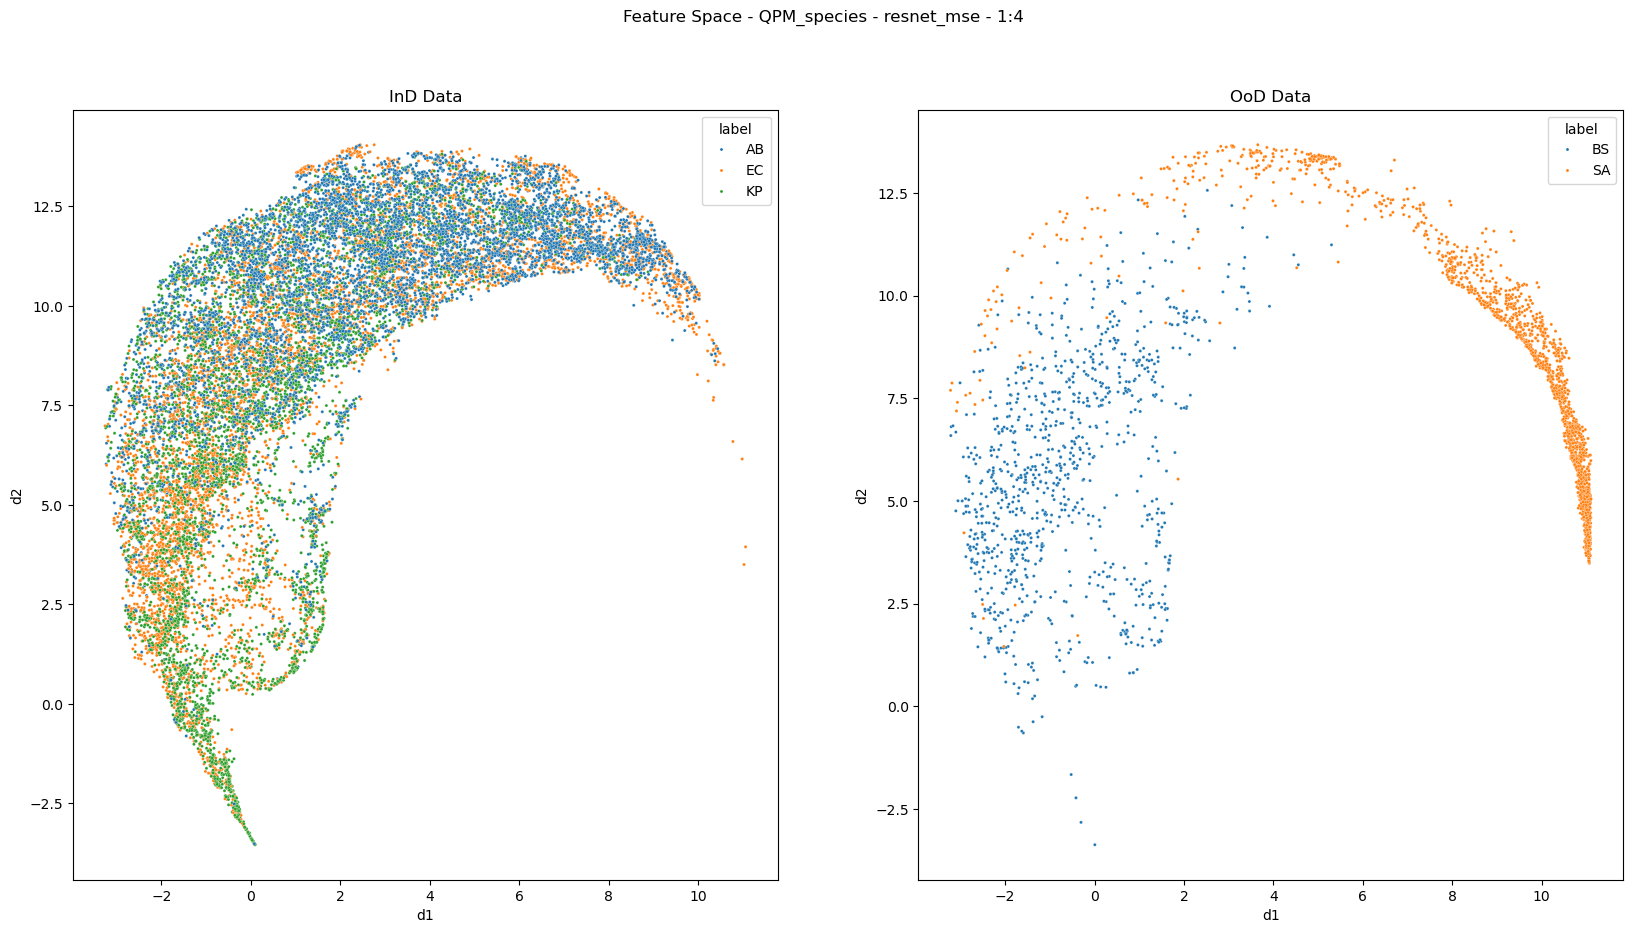

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

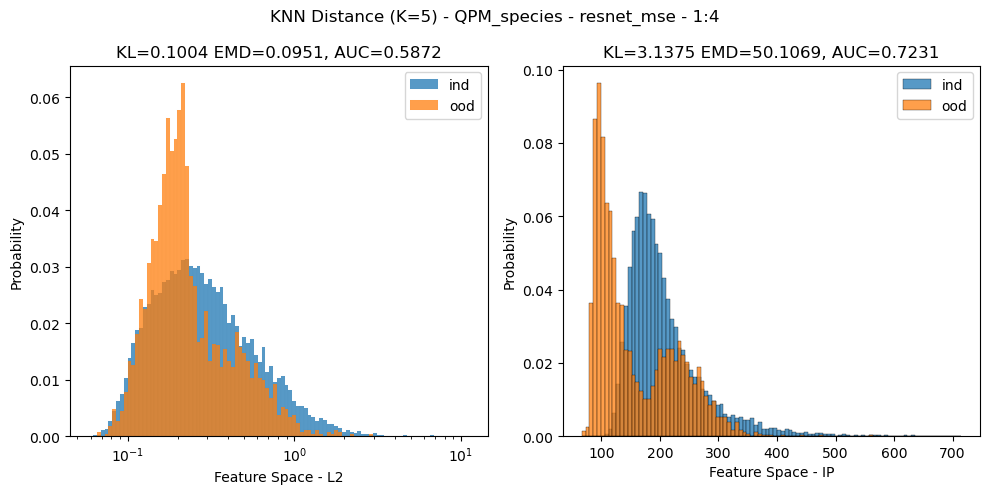

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

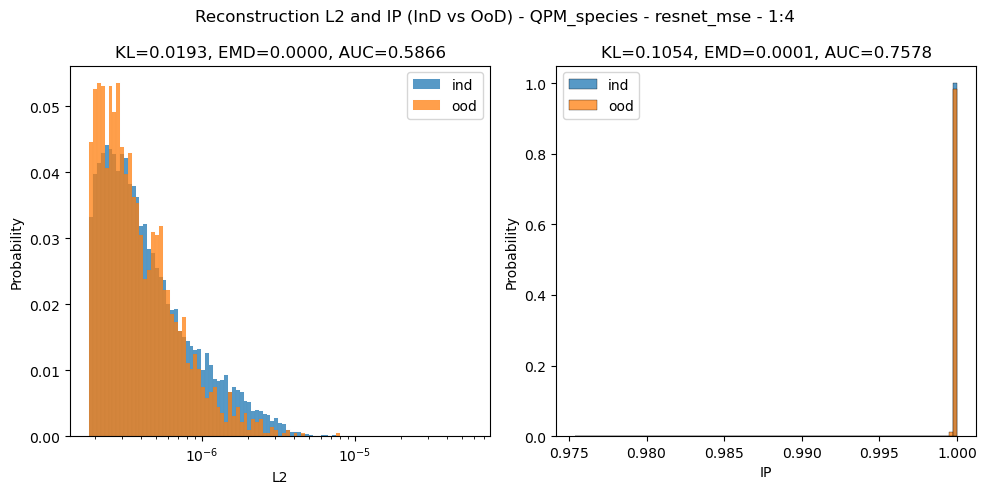

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)